# Necessary Imports
In this section, we will import the necessary libraries for training our Random Forest (RF) model. This includes libraries for data manipulation, model building, and evaluation.

In [2]:
# system and utility imports
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from joblib import dump
import seaborn as sns

# sklearn metrics and utilities
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score, accuracy_score, confusion_matrix, 
    classification_report, auc, precision_score, 
    recall_score, f1_score, log_loss
)

from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

# sklearn Model and Hyperparameter Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# tensorFlow/Keras for loading models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# Image Loading and Preprocessing Functions
We shall create several functions for loading and preprocessing images from a specified directory. The functions perform the following tasks:

1. **Check if a file is an image:** A helper function that determines if a given filename has an image file extension (specifically `.jpg`).

2. **Load and preprocess an image:** A function that loads an image from a specified path, resizes it to a target size (defaulting to 128x128 pixels), normalizes pixel values to be between 0 and 1, and ensures that the image has three color channels (RGB).

3. **Load images from a directory:** A function that walks through a specified directory, loads and preprocesses images, and assigns them a label (either fraudulent or non-fraudulent) based on the provided input.

4. **Set base directory and load training images:** The base directory for the dataset is specified, along with paths to the training data subdirectories for fraudulent and non-fraudulent images. The training images are then loaded and labeled accordingly.

In [4]:
# function to check if a file is an image
def is_image_file(filename):
    return filename.lower().endswith('.jpg')

In [5]:
# function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # load image
    image = Image.open(img_path)
    
    # resize image to target size
    image = image.resize(target_size)
    
    # convert image to array and normalize (pixel values between 0 and 1)
    image = np.array(image) / 255.0
    
    # ensure image has 3 channels (RGB)
    if len(image.shape) == 2:  # If grayscale, convert to RGB
        image = np.stack((image,) * 3, axis=-1)
    elif image.shape[2] == 4:  # If RGBA, convert to RGB
        image = image[:, :, :3]
    
    return image

In [6]:
# function to load images from a directory and assign labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                img_path = os.path.join(root, file)
                image = load_and_preprocess_image(img_path)  # Load and preprocess
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [7]:
# base directory for the dataset
directory = 'vehicle_insurance_dataset'

# set paths for training data subdirectories
train_fraud_dir = os.path.join(directory, 'train', 'fraud')
train_non_fraud_dir = os.path.join(directory, 'train', 'non-fraud')

# load and label the training images for fraud and non-fraud cases
train_images_fraud, train_labels_fraud = load_images_from_directory(train_fraud_dir, 1)
train_images_non_fraud, train_labels_non_fraud = load_images_from_directory(train_non_fraud_dir, 0)

print(f"Train images (fraud) shape: {train_images_fraud.shape}")
print(f"Train labels (fraud) shape: {train_labels_fraud.shape}")
print(f"Train images (non-fraud) shape: {train_images_non_fraud.shape}")
print(f"Train labels (non-fraud) shape: {train_labels_non_fraud.shape}")

Train images (fraud) shape: (372, 128, 128, 3)
Train labels (fraud) shape: (372,)
Train images (non-fraud) shape: (6091, 128, 128, 3)
Train labels (non-fraud) shape: (6091,)


# Reshape the Image Data for SMOTE
To apply Synthetic Minority Over-sampling Technique (SMOTE) to image data, we need to first reshape the images into a flat format. This process involves:

1. **Flattening Fraud and Non-Fraud Images:**  
   Both fraud and non-fraud images are reshaped into two-dimensional arrays, where each image is represented as a single vector of pixel values.

2. **Creating Labels:**  
   Labels are assigned to the images: `1` for fraud and `0` for non-fraud.

3. **Combining Data:**  
   The flattened fraud and non-fraud images are combined into one dataset. Similarly, the corresponding labels are also combined.

This reshaped dataset is now ready for SMOTE, which will help in addressing class imbalance by synthetically generating new fraud examples.

In [9]:
# reshape the image data for SMOTE
fraud_images_flat = train_images_fraud.reshape(train_images_fraud.shape[0], -1)
non_fraud_images_flat = train_images_non_fraud.reshape(train_images_non_fraud.shape[0], -1)

# create labels for fraud (1) and non-fraud (0)
fraud_labels = np.ones(train_images_fraud.shape[0])
non_fraud_labels = np.zeros(train_images_non_fraud.shape[0])

# combine images and labels
smote_rf_combined_images_flat = np.vstack((fraud_images_flat, non_fraud_images_flat))
smote_rf_combined_labels = np.hstack((fraud_labels, non_fraud_labels))

# Load the SMOTE Model from a File Using Joblib
In this step, we load a previously saved SMOTE model (from data pre-processing step) from a file using the `joblib` library. Loading the model allows us to reuse the pre-trained SMOTE model without having to train it again.

- **Purpose:**  
  To load the SMOTE model that was previously saved in the file `'smote_model.pkl'`.

- **Benefit:**  
  This saves time and computational resources by avoiding retraining and directly utilizing the pre-trained model for generating synthetic samples.

In [11]:
# load the SMOTE model from the file using joblib
smote_rf_model_loaded = joblib.load('smote_model.pkl')

# print the loaded model's class name and parameters
print(f"Loaded model: {smote_rf_model_loaded.__class__.__name__}")
print(f"Model parameters: {smote_rf_model_loaded.get_params()}")

Loaded model: SMOTE
Model parameters: {'k_neighbors': 5, 'n_jobs': None, 'random_state': None, 'sampling_strategy': 'auto'}


# Apply SMOTE to Oversample the Fraud Class in the Training Data
In this step, we apply the loaded SMOTE model to oversample the fraud class in our training dataset. The process includes the following steps:

1. **Resample the Data:**  
   SMOTE is applied to the flattened image data (`smote_rf_combined_images_flat`) and corresponding labels (`smote_rf_combined_labels`). This generates synthetic examples for the minority class (fraud), resulting in a balanced dataset.

2. **Separate Resampled Fraud and Non-Fraud Images:**  
   The resampled data is split back into fraud and non-fraud images based on their labels.

3. **Reshape Resampled Images:**  
   The flattened resampled fraud and non-fraud images are reshaped back into their original image dimensions (height, width, and channels).

4. **Combine Resampled Fraud and Non-Fraud Images:**  
   The resampled fraud images are combined with the original non-fraud images to form the final balanced training set.

5. **Check the Balanced Dataset:**  
   The shapes of the balanced images and labels are displayed to ensure that the dataset is correctly balanced, with equal representation of fraud and non-fraud examples.

In [13]:
# apply SMOTE to oversample the fraud class in the training data
X_resampled_smote_rf, y_resampled_smote_rf= smote_rf_model_loaded.fit_resample(smote_rf_combined_images_flat, smote_rf_combined_labels)

# separate resampled fraud and non-fraud images
X_fraud_resampled_smote_rf = X_resampled_smote_rf[y_resampled_smote_rf == 1]
X_non_fraud_resampled_smote_rf = X_resampled_smote_rf[y_resampled_smote_rf == 0]

# reshape the resampled fraud images and the original non-fraud images back into the image shape
image_height_smote_rf, image_width_smote_rf, image_channels_smote_rf = train_images_fraud.shape[1], train_images_fraud.shape[2], train_images_fraud.shape[3]
X_fraud_resampled_smote_rf_images = X_fraud_resampled_smote_rf.reshape(-1, image_height_smote_rf, image_width_smote_rf, image_channels_smote_rf)
X_non_fraud_resampled_smote_rf_images = X_non_fraud_resampled_smote_rf.reshape(-1, image_height_smote_rf, image_width_smote_rf, image_channels_smote_rf)

# combine resampled fraud images and non-fraud images
X_train_balanced_smote_rf = np.vstack((X_fraud_resampled_smote_rf_images, X_non_fraud_resampled_smote_rf_images))
y_train_balanced_smote_rf = np.hstack((np.ones(X_fraud_resampled_smote_rf_images.shape[0]), np.zeros(X_non_fraud_resampled_smote_rf_images.shape[0])))

# display the shapes of the balanced data
print(f"Balanced train images shape: {X_train_balanced_smote_rf.shape}")
print(f"Balanced train labels shape: {y_train_balanced_smote_rf.shape}")


Balanced train images shape: (12182, 128, 128, 3)
Balanced train labels shape: (12182,)


# Denoising Function
We will create a function to load the saved denoising model for processing images using a Deep Convolutional Autoencoder (DCAE). The function performs the following tasks:

1. **Load the DCAE model:** The model is loaded from a specified path to be used for denoising the images.

2. **Denoise fraud and non-fraud images:** The function uses the loaded DCAE model to predict and denoise both fraudulent and non-fraudulent images.

3. **Print shapes of the denoised datasets:** The shapes of the resulting denoised image arrays for both the fraud and non-fraud datasets are printed to provide insight into the transformation.

The function then returns the denoised images for both categories, which can be further utilized in model training or evaluation.

In [15]:
# function to denoise
def denoise_images_with_dcae(fraud_images, non_fraud_images, dcae_model_path):
    # load the DCAE model for denoising
    dcae_model = load_model(dcae_model_path)
    print("DCAE model loaded.")

    # denoising fraud and non-fraud images
    fraud_images_denoised_smote_rf = dcae_model.predict(fraud_images)
    non_fraud_images_denoised_smote_rf_smote_rf = dcae_model.predict(non_fraud_images)

    # print the shape of the denoised datasets
    print(f"Denoised Fraud dataset shape: {fraud_images_denoised_smote_rf.shape}")
    print(f"Denoised Non-Fraud dataset shape: {non_fraud_images_denoised_smote_rf_smote_rf.shape}")

    return fraud_images_denoised_smote_rf, non_fraud_images_denoised_smote_rf_smote_rf

# Denoise the Balanced Fraud and Non-Fraud Images
This step applies a pre-trained Deep Convolutional Autoencoder (DCAE) model to denoise both fraud and non-fraud images in the balanced dataset. The process involves:

1. **Denoising Fraud Images:**  
   The combined set of original and SMOTE-generated fraud images is passed through the DCAE model to remove noise and improve image quality.

2. **Denoising Non-Fraud Images:**  
   The original non-fraud images from the training data are also denoised using the same DCAE model.

3. **Using a Pre-Trained DCAE Model:**  
   The DCAE model is loaded from the specified path (`'dcae_model.keras'`) and applied to both sets of images, producing cleaner versions of the fraud and non-fraud images.

By denoising the images, we aim to improve the performance of subsequent models trained on this dataset.

In [17]:
# denoise the balanced fraud and non-fraud images
fraud_images_denoised_smote_rf, non_fraud_images_denoised_smote_rf_smote_rf = denoise_images_with_dcae(
    X_fraud_resampled_smote_rf_images,  # combined original + SMOTE-generated fraud images
    X_non_fraud_resampled_smote_rf_images,  # original non-fraud images from the training data
    'dcae_model.keras'  # DCAE model path
)

DCAE model loaded.
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step
Denoised Fraud dataset shape: (6091, 128, 128, 3)
Denoised Non-Fraud dataset shape: (6091, 128, 128, 3)


# Combine Denoised Fraud and Non-Fraud Images
In this step, we combine the denoised fraud and non-fraud images into a single balanced dataset. The process includes the following:

1. **Combine Denoised Fraud and Non-Fraud Images:**  
   The denoised fraud images (both original and SMOTE-generated) are combined with the denoised non-fraud images to form the complete training dataset.

2. **Generate Labels for Fraud and Non-Fraud Classes:**  
   Labels are created for the combined dataset, where fraud images are labeled as 1 and non-fraud images as 0. The labels correspond to the images in the same order.

3. **Shuffle Images and Labels:**  
   The dataset is shuffled to ensure randomness. Both the denoised images and corresponding labels are shuffled together using the same indices, maintaining label-image alignment.

4. **Verify Dataset Shape:**  
   Finally, the shapes of the combined and shuffled images and labels are displayed to confirm that the dataset has been correctly formed and balanced.

This step ensures that the denoised dataset is ready for training with equal representation of fraud and non-fraud examples, in a randomized order.

In [19]:
# combine denoised fraud and non-fraud images
balanced_images_denoised_smote_rf = np.vstack((fraud_images_denoised_smote_rf, non_fraud_images_denoised_smote_rf_smote_rf))

# combine labels for fraud (1) and non-fraud (0) as they were defined earlier
balanced_train_labels_denoised_smote_rf = np.hstack((np.ones(fraud_images_denoised_smote_rf.shape[0]), np.zeros(non_fraud_images_denoised_smote_rf_smote_rf.shape[0])))

# shuffle both images and labels together
indices = np.arange(balanced_images_denoised_smote_rf.shape[0])
np.random.shuffle(indices)

balanced_images_denoised_smote_rf = balanced_images_denoised_smote_rf[indices]
balanced_train_labels_denoised_smote_rf = balanced_train_labels_denoised_smote_rf[indices]

# verify the shape of the shuffled and combined datasets
print(f"Combined Fraud & Non-Fraud train dataset shape: {balanced_images_denoised_smote_rf.shape}")
print(f"Combined Fraud & Non-Fraud train label dataset shape: {balanced_train_labels_denoised_smote_rf.shape}")


Combined Fraud & Non-Fraud train dataset shape: (12182, 128, 128, 3)
Combined Fraud & Non-Fraud train label dataset shape: (12182,)


### Class Weights Setup for Random Forest Model
We define the class labels for our binary classification task, where `0` represents non-fraud and `1` represents fraud. Class weights are computed based on the distribution of these labels in the training data to handle any class imbalance. A dictionary is created to manually set the weights for both classes, and these weights are passed to the Random Forest classifier to ensure that it properly accounts for the imbalance during training.

In [21]:
# class labels
class_labels_smote_rf = np.array([0, 1])  # 0 is non-fraud, 1 is fraud

# calculate the class weights based on the training labels
class_weights_smote_rf = compute_class_weight('balanced', classes=class_labels_smote_rf, y=balanced_train_labels_denoised_smote_rf)

# create a dictionary for class weights
class_weight_dict_smote_rf = {0: 1, 1: 5.0}

# initialize the Random Forest model and pass this dictionary to GridSearchClassifier
rf_classifier_smote_rf = RandomForestClassifier(random_state=42, class_weight=class_weight_dict_smote_rf)
print(f"Random Forest model initialized with class weights: {class_weight_dict_smote_rf}")

Random Forest model initialized with class weights: {0: 1, 1: 5.0}


# Flatten the Images for Random Forest
To prepare the data for training the Random Forest model, the images are first flattened into 1D arrays. This transformation is necessary because Random Forest models do not natively process multi-dimensional image data. The labels corresponding to the images are also assigned appropriately.

#### Steps:
1. **Flatten the images**: Each image in the dataset is reshaped into a 1D array. This ensures compatibility with the Random Forest model, which requires tabular input data.
2. **Assign labels**: The corresponding labels for the images are assigned to the variable `y_flat_smote_rf`.
3. **Split the data**: The dataset is split into training and validation sets to allow for model evaluation during training. This ensures that 20% of the data is reserved for validation, maintaining the label distribution with stratification.

In [23]:
# flatten the images for Random Forest, if necessary
X_flat_smote_rf = balanced_images_denoised_smote_rf.reshape(balanced_images_denoised_smote_rf.shape[0], -1) 
y_flat_smote_rf = balanced_train_labels_denoised_smote_rf 

# split the data
X_train_flat_smote_rf, X_val_flat_smote_rf, y_train_flat_smote_rf, y_val_flat_smote_rf = train_test_split(
    X_flat_smote_rf, y_flat_smote_rf, test_size=0.2, random_state=42, stratify=y_flat_smote_rf
)

### Initialize GridSearchCV with the Parameter Grid

In this step, we configure `GridSearchCV` to optimize the hyperparameters of the Random Forest model. The key components of this setup are:

- **`estimator`**: The Random Forest classifier initialized earlier.
- **`param_grid`**: A predefined grid of hyperparameters to explore, including options for the number of trees, tree depth, and splitting criteria.
- **`cv`**: We use 5-fold cross-validation to evaluate the model's performance during the hyperparameter search, ensuring robust validation.
- **`verbose`**: Set to 2 for detailed logging of the fitting process.
- **`n_jobs`**: Runs in parallel using a single job (`n_jobs=1`) for compatibility and resource management.
- **`scoring`**: The F1 score is used as the metric to evaluate model performance, focusing on the balance between precision and recall.

After fitting the model on the training data, we extract the best hyperparameters and evaluate their performance on the validation set. 

### PCA Transformation

To improve efficiency and potentially enhance model performance, Principal Component Analysis (PCA) is applied to reduce the dimensionality of the training and validation datasets. This step ensures that redundant features are minimized, making the dataset more suitable for Random Forest training.

### Saving the Model

Once the best Random Forest model and PCA transformation are identified, they are saved together using `joblib` for future use. This ensures reproducibility and avoids the need to re-train the model and re-apply PCA on the dataset.

### Evaluation and Results

The best Random Forest model is evaluated on the validation set using the reduced feature set. Key performance metrics, such as the confusion matrix and classification report, are printed to analyze the model's precision, recall, and F1 score. These metrics provide a comprehensive view of the model's effectiveness in detecting fraudulent claims.

In [25]:
# apply PCA
pca_smote = PCA(n_components=50, random_state=42)
X_train_smote_pca = pca_smote.fit_transform(X_train_flat_smote_rf)  # fit and transform on training data
X_val_smote_pca = pca_smote.transform(X_val_flat_smote_rf)          # transform validation data

# define and train the Random Forest model
rf_classifier_smote_rf = RandomForestClassifier(random_state=42)

# hyperparameter grid to search
param_grid_smote = {
    'n_estimators': [25, 50, 75],            # number of trees
    'max_depth': [10, 20, 30, None],         # maximum depth of trees
    'min_samples_split': [2, 5, 10],         # minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']         # number of features to consider for splitting
}

# setup GridSearchCV with 5-fold cross-validation
grid_search_smote = GridSearchCV(
    estimator=rf_classifier_smote_rf, 
    param_grid=param_grid_smote, 
    cv=5, 
    n_jobs=1, 
    verbose=2, 
    scoring='f1'
)

# fit the model on the training data
grid_search_smote.fit(X_train_smote_pca, y_train_flat_smote_rf)

# display best hyperparameters and performance
print("Best Hyperparameters: ", grid_search_smote.best_params_)
print("Best Cross-Validation F1 Score: ", grid_search_smote.best_score_)

# evaluate the model with best hyperparameters on the validation set
best_smote_rf_classifier = grid_search_smote.best_estimator_
y_val_smote_pred = best_smote_rf_classifier.predict(X_val_smote_pca)

# print evaluation metrics
print("Confusion Matrix (Validation):\n", confusion_matrix(y_val_flat_smote_rf, y_val_smote_pred))
print("Classification Report (Validation):\n", classification_report(y_val_flat_smote_rf, y_val_smote_pred))

# save PCA and Random Forest together
joblib.dump({'rf_classifier': best_smote_rf_classifier, 'pca': pca_smote}, 'rf_smote_with_pca.pkl')
print("Random Forest and PCA saved as rf_smote_with_pca.pkl")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; tot

### Loading Test Images and Labels

In this step, we load the test images and assign their respective labels. The test dataset is divided into two categories:

1. **Fraud Images**: These are labeled as `1` to represent fraudulent claims.
2. **Non-Fraud Images**: These are labeled as `0` to represent legitimate claims.

The `load_images_from_directory` function is used to load the images from their respective directories and assign labels based on the category.

#### Test Directory Paths
- **Fraud Images**: Directory containing the test fraud images.
- **Non-Fraud Images**: Directory containing the test non-fraud images.

After loading the images, we print the shapes of the loaded datasets to confirm successful loading and labeling.

In [27]:
# set paths to the test directories
test_fraud_dir = os.path.join(directory, 'test','fraud')
test_non_fraud_dir = os.path.join(directory,'test', 'non-fraud')

# load and label the test images
test_images_fraud_smote_rf, test_labels_fraud_smote_rf = load_images_from_directory(test_fraud_dir, 1)
test_images_non_fraud_smote_rf, test_labels_non_fraud_smote_rf = load_images_from_directory(test_non_fraud_dir, 0)

print(f"Test images fraud shape: {test_images_fraud_smote_rf.shape}")
print(f"Test fraud labels shape: {test_labels_fraud_smote_rf.shape}")

print(f"Test images non_fraud shape: {test_images_non_fraud_smote_rf.shape}")
print(f"Test non_fraud labels shape: {test_labels_non_fraud_smote_rf.shape}")

Test images fraud shape: (93, 128, 128, 3)
Test fraud labels shape: (93,)
Test images non_fraud shape: (1523, 128, 128, 3)
Test non_fraud labels shape: (1523,)


### Combining and Shuffling Test Images and Labels

To prepare the test dataset for evaluation, we combine the test images and labels from both the fraud and non-fraud categories into unified arrays. This ensures the model is tested on a mixed and randomized dataset, reducing potential bias during evaluation.

#### Steps:
1. **Concatenation of Test Images and Labels**:
   - The fraud and non-fraud images are merged into a single array, `test_images_smote_rf`.
   - Their respective labels are combined into `test_labels_smote_rf`.

2. **Shuffling the Data**:
   - An array of indices representing sample positions is generated.
   - These indices are shuffled randomly to reorder the images and labels.

3. **Reordering**:
   - The test images and labels are reordered based on the shuffled indices to ensure randomness in the test dataset.

After these steps, we log the shapes of the combined and shuffled datasets to confirm successful preparation.

In [29]:
# combine the test images and labels
test_images_smote_rf = np.concatenate(
    (test_images_fraud_smote_rf, test_images_non_fraud_smote_rf), axis=0
)
test_labels_smote_rf = np.concatenate(
    (test_labels_fraud_smote_rf, test_labels_non_fraud_smote_rf), axis=0
)

# shuffle the test data randomly to prevent bias during testing
indices = np.arange(test_images_smote_rf.shape[0])  # generate an array of indices
np.random.shuffle(indices)  # shuffle the indices randomly

# reorder the images and labels according to the shuffled indices
test_images_smote_rf = test_images_smote_rf[indices]
test_labels_smote_rf = test_labels_smote_rf[indices]

# log the shapes of the combined and shuffled datasets
print(f"Combined test images shape: {test_images_smote_rf.shape}")
print(f"Combined test labels shape: {test_labels_smote_rf.shape}")

Combined test images shape: (1616, 128, 128, 3)
Combined test labels shape: (1616,)


### Loading the Classification Model and Making Predictions

In this step, we load the pre-trained Random Forest classification model, process the denoised test images, and make predictions on them. 

#### Steps:

1. **Load the Model**:
   - The saved model (`rf_smote_with_pca.pkl`), which includes the Random Forest classifier and PCA, is loaded successfully.

2. **Prepare Test Images**:
   - The denoised test images are flattened into a 2D array to match the model's expected input format.
   - PCA is applied to reduce the dimensionality of the flattened images.

3. **Make Predictions**:
   - The Random Forest model predicts the class labels for the processed test images.

4. **Evaluate the Model**:
   - The predicted labels are evaluated against the true labels using a classification report and a confusion matrix.

This process ensures accurate testing of the model on a well-prepared dataset.

In [31]:
# load the saved Random Forest model with PCA
model_data = joblib.load('rf_smote_with_pca.pkl')  # load the dictionary containing the classifier and PCA
best_rf_classifier_smote_rf = model_data['rf_classifier']
pca_smote_rf = model_data['pca']
print("Model and PCA loaded successfully.")

# flatten the denoised test images for the Random Forest model
flattened_test_images_smote_rf = test_images_smote_rf.reshape(
    test_images_smote_rf.shape[0], -1
)  # Flatten to shape (num_samples, 128*128*3)

# apply PCA to the flattened test images
test_images_smote_rf_pca = pca_smote_rf.transform(flattened_test_images_smote_rf)  # reduce dimensionality

# predict labels using the Random Forest model
test_probs_smote_rf = best_rf_classifier_smote_rf.predict(test_images_smote_rf_pca)  # predict the class labels
print(f"Predicted Labels: {test_probs_smote_rf}")

# generate and print the classification report and confusion matrix
print("Classification Report:\n", classification_report(test_labels_smote_rf, test_probs_smote_rf))
print("Confusion Matrix:\n", confusion_matrix(test_labels_smote_rf, test_probs_smote_rf))

Model and PCA loaded successfully.
Predicted Labels: [0. 0. 0. ... 0. 0. 0.]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1523
           1       0.59      0.54      0.56        93

    accuracy                           0.95      1616
   macro avg       0.78      0.76      0.77      1616
weighted avg       0.95      0.95      0.95      1616

Confusion Matrix:
 [[1488   35]
 [  43   50]]


# Model Evaluation and Performance Visualization

In this section, we assess the performance of our classification model using various evaluation metrics and visualize its results with ROC and Precision-Recall curves.

### Key Steps:

1. **Function Definitions**:
   - **`plot_confusion_matrix(conf_matrix)`**: Displays a heatmap of the confusion matrix, providing insights into the model's classification accuracy for 'Fraud' and 'Non-Fraud' cases.
   - **`evaluate_model(model, model_name, test_images, test_labels, threshold=0.5)`**: 
     - Evaluates the model using accuracy, precision, recall, F1-score, AUC, and AP metrics.
     - Visualizes the confusion matrix and prints calculated metrics.

2. **Confusion Matrix**:
   - Computed using the true labels and predicted probabilities.
   - Visualized as a heatmap to highlight the model's performance in distinguishing between fraud and non-fraud cases.

3. **ROC Curve and AUC Calculation**:
   - Plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for varying thresholds.
   - AUC (Area Under the Curve) quantifies the model's overall ability to differentiate between classes.

4. **Precision-Recall Curve**:
   - Plots precision against recall for various thresholds.
   - Highlights the trade-off between precision and recall, particularly useful for imbalanced datasets.

5. **Visualization**:
   - We display both the ROC curve and the Precision-Recall curve side by side for a comprehensive view of the model's performance.

---

### Visualizations

1. **Confusion Matrix**:
   - A heatmap illustrates the relationship between true and predicted labels for 'Fraud' and 'Non-Fraud' cases.

2. **ROC Curve**:
   - Shows the balance between sensitivity (True Positive Rate) and specificity (False Positive Rate).
   - Includes a random guess baseline for comparison.

3. **Precision-Recall Curve**:
   - Explores the balance between precision and recall.
   - Useful for understanding performance in scenarios with imbalanced class distributions.

These visualizations provide a detailed overview of the model's classification effectiveness, supporting a comprehensive evaluation of its strengths and areas for improvement.

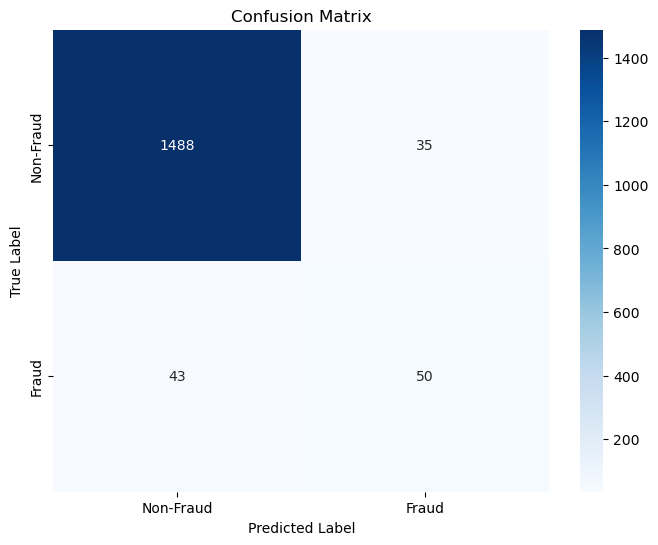

In [33]:
# calculate the confusion matrix
cm = confusion_matrix(test_labels_smote_rf, test_probs_smote_rf)

# create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

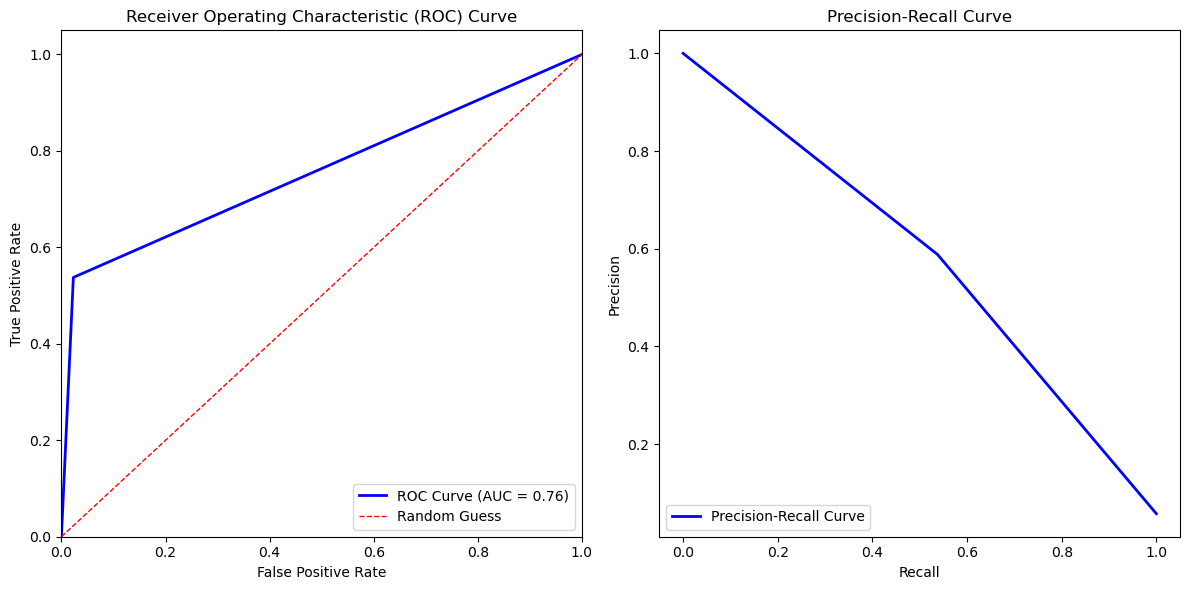

In [34]:
# calculate ROC curve
fpr, tpr, _ = roc_curve(test_labels_smote_rf, test_probs_smote_rf)
roc_auc_value = auc(fpr, tpr)  # Calculate the Area Under the Curve (AUC)

# calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels_smote_rf, test_probs_smote_rf)

# plot ROC and Precision-Recall curves
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=1, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# adjust layout and display the plots
plt.tight_layout()
plt.show()

# Model Evaluation on Denoised Test Images

In this section, we evaluate the performance of our Random Forest model on the denoised test images. The evaluation focuses on two primary metrics—loss and accuracy—to provide a clear understanding of the model's capability in distinguishing between fraudulent and non-fraudulent cases.

---

### Model Evaluation:
1. **PCA Transformation**:
   - The test images are transformed using PCA to reduce dimensionality while preserving important information.

2. **Predictions**:
   - Predicted probabilities and class labels are generated using the trained Random Forest model on the PCA-transformed test images.

3. **Metrics**:
   - **Accuracy**: Measures the proportion of correctly predicted labels.
   - **Loss**: Calculated using `log_loss`, it indicates the extent of prediction error, with lower values signifying better performance.

---

### Results Visualization:
To provide an intuitive representation of the model's performance, a **horizontal bar chart** is created. The chart displays:
- **Test Loss**: Lower values are better, reflecting minimal prediction error.
- **Test Accuracy**: Higher values are better, signifying correct classification of test images.

---

### Code Overview:
1. **Transform Test Set**: The test images are flattened and passed through the PCA transformation.
2. **Model Predictions**: The transformed test set is used to predict probabilities and class labels.
3. **Calculate Metrics**: Test loss and accuracy are computed using standard evaluation functions.
4. **Bar Chart Visualization**: A horizontal bar chart is generated to visualize the loss and accuracy side by side.

---

### Visualization Details:
- **Bar Chart**:
  - Each bar represents one of the metrics (Test Loss or Test Accuracy).
  - Value labels are placed on top of each bar for quick reference.
  - The chart is styled with distinct colors, a grid for readability, and adjusted axis limits for clarity.

Test Loss: 0.3443
Test Accuracy: 0.9517


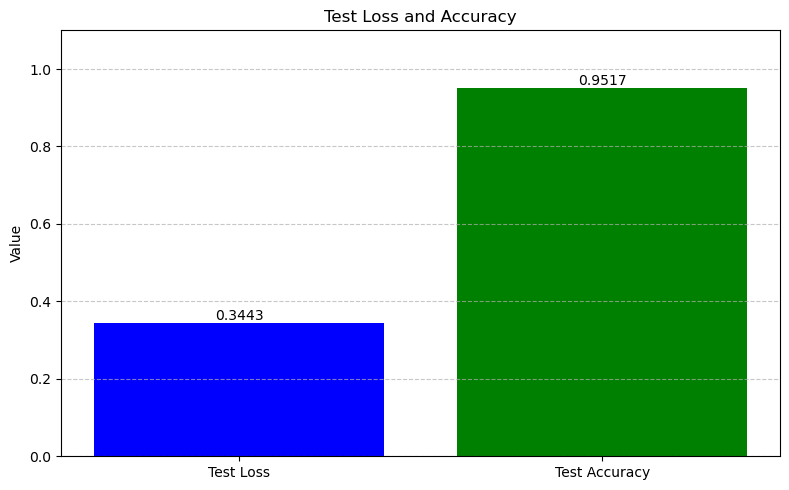

In [36]:
# apply PCA transformation to the test set
flattened_test_images_smote_rf_pca = pca_smote.transform(flattened_test_images_smote_rf)

# make predictions on the transformed test set
predicted_probs_smote_rf = best_rf_classifier_smote_rf.predict_proba(flattened_test_images_smote_rf_pca)  # get predicted probabilities
predicted_labels_smote_rf = best_rf_classifier_smote_rf.predict(flattened_test_images_smote_rf_pca)  # get predicted classes

# calculate test accuracy and loss
test_accuracy_smote_rf = accuracy_score(test_labels_smote_rf, predicted_labels_smote_rf)
test_loss_smote_rf = log_loss(test_labels_smote_rf, predicted_probs_smote_rf)

# display the test loss and accuracy
print(f"Test Loss: {test_loss_smote_rf:.4f}")
print(f"Test Accuracy: {test_accuracy_smote_rf:.4f}")

# data for plotting
metrics = ['Test Loss', 'Test Accuracy']
values = [test_loss_smote_rf, test_accuracy_smote_rf]

# create a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['blue', 'green'])

# add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.4f}", ha='center', va='bottom')

# adding title and labels
plt.title('Test Loss and Accuracy')
plt.ylabel('Value')
plt.ylim(0, 1.1)  # adjust y-axis limits slightly above 1 for visibility

# show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)  # add grid lines for better readability
plt.tight_layout()
plt.show()

# Evaluation Results

After evaluating the model on the denoised test images, we obtained the following results:

- **Test Loss:** 0.3443
- **Test Accuracy:** 95.17%

These metrics indicate that the model performed very well, achieving an accuracy of 95.17% in classifying the test images.

# Function to Load Unlabeled Validation Images

This function facilitates the loading of images from a validation dataset that does not require labels. It is particularly useful when working with datasets where labels are not provided but the images need preprocessing or model inference.

---

### Function: `load_unalabelled_images_from_directory`

#### **Purpose**:
To load images from a specified directory, preprocess them into arrays suitable for model input, and optionally associate labels with them if provided.

---

### Parameters:
1. **`directory`** (str): Path to the directory containing the images to be loaded.
2. **`label`** (Optional): If a label is provided, it is appended to each loaded image. Defaults to `None`.

---

### Returns:
- **Images Only**: If `label` is not provided, the function returns a NumPy array of loaded images.
- **Images and Labels**: If `label` is provided, the function returns two NumPy arrays—one for images and one for corresponding labels.

---

### Steps:
1. **Initialize Containers**:
   - Empty lists `images` and `labels` to store loaded image arrays and labels.

2. **Directory Traversal**:
   - The `os.walk` method is used to traverse all subdirectories and files within the given directory.

3. **Image Loading and Preprocessing**:
   - For each file that is recognized as an image (checked using `is_image_file`):
     - Load the image using `load_img`.
     - Resize it to `(128, 128)`.
     - Convert the image into an array using `img_to_array`.
     - Append the image to the `images` list.

4. **Label Assignment** (Optional):
   - If a label is provided, it is appended to the `labels` list for each loaded image.

5. **Conversion to NumPy Arrays**:
   - The `images` list is converted into a NumPy array for consistency with machine learning workflows.
   - If labels were provided, the `labels` list is also converted into a NumPy array.

6. **Return Values**:
   - Return images (and labels if provided).

In [39]:
# function to load unlabelled validation images
def load_unalabelled_images_from_directory(directory, label=None):
    images = []
    labels = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_path = os.path.join(root, file)
                image = load_img(image_path, target_size=(128, 128))  # load image
                image = img_to_array(image)  # convert to array
                images.append(image)
                
                # append label if provided
                if label is not None:
                    labels.append(label)
    
    images = np.array(images)
    
    if label is not None:
        labels = np.array(labels)
        return images, labels
    
    return images

In [40]:
# load validation images from the 'sol' directory
val_dir = os.path.join(directory, 'sol')
val_images = load_unalabelled_images_from_directory(val_dir)

# check if validation images are loaded
if val_images is None or len(val_images) == 0:
    raise ValueError("Validation images could not be loaded. Please check the validation directory, named 'sol'.")
else:
    print(f"Validation images loaded successfully. Shape: {val_images.shape}")

Validation images loaded successfully. Shape: (3462, 128, 128, 3)


# Validation Predictions on Denoised Images

In this section, we process the denoised validation images and predict their labels using a trained Random Forest (RF) model. The goal is to classify the images as either 'Fraudulent' or 'Non-Fraudulent' based on their content.

---

### Key Steps:

1. **Image Preparation**:
   - The denoised validation images are reshaped into a flat format to ensure compatibility with the model's input requirements.

2. **Model Loading**:
   - The trained RF model, along with the PCA transformer, is loaded from the saved file (`rf_smote_with_pca.pkl`).

3. **PCA Transformation**:
   - The flattened validation images are transformed using the PCA model to match the input format of the RF classifier.

4. **Prediction**:
   - The RF model predicts the labels for the validation images.
   - Predicted labels are converted into binary format: `0` (Non-Fraud) and `1` (Fraud).

5. **Verification**:
   - Shapes of the validation images and the predicted labels are printed to confirm correctness.

In [42]:
# load the classification model
smote_rf_model_name = 'rf_smote_with_pca.pkl'
smote_rf_classification_model = joblib.load(smote_rf_model_name)
print(f"Model '{smote_rf_model_name}' loaded successfully.")

# extract the Random Forest classifier and PCA transformer from the dictionary
rf_classifier_smote_rf = smote_rf_classification_model['rf_classifier']
pca_smote_rf = smote_rf_classification_model['pca']

# flatten the validation images
val_images_flattened_smote_rf = val_images.reshape(val_images.shape[0], -1)  # flattening the validation images

# apply PCA transformation to the validation images
val_images_pca_smote_rf = pca_smote_rf.transform(val_images_flattened_smote_rf)

# predict labels for the validation images
val_labels_smote_rf = rf_classifier_smote_rf.predict(val_images_pca_smote_rf)

# verify the shape of the validation images and predicted labels
print(f"Validation Images Shape (flattened): {val_images_flattened_smote_rf.shape}")
print(f"Predicted Validation Labels Shape: {val_labels_smote_rf.shape}")

# print the predicted labels
print(f"Predicted Validation Labels: {val_labels_smote_rf}")

Model 'rf_smote_with_pca.pkl' loaded successfully.
Validation Images Shape (flattened): (3462, 49152)
Predicted Validation Labels Shape: (3462,)
Predicted Validation Labels: [0. 0. 0. ... 0. 0. 0.]


# Validation Predictions on Unlabeled Images

In this section, we process the unlabeled validation images and predict their labels using the trained Random Forest model. The results provide insights into the classification of images as either 'Fraudulent' or 'Non-Fraudulent.'

---

### Key Steps:

1. **Image Path Retrieval**:
   - A custom function retrieves all image paths from the validation directory.
   - The function ensures only valid image files are included for processing.

2. **Prediction DataFrame**:
   - A DataFrame is created to store:
     - Image paths.
     - Predicted labels (0 for non-fraud, 1 for fraud).
     - Classification results as 'fraud' or 'non-fraud'.

3. **Prediction Analysis**:
   - The counts of 'fraud' and 'non-fraud' predictions are computed and displayed.
   - This provides a quick overview of the model's classification results.

4. **Results Export**:
   - The prediction results are exported to a CSV file (`smote_rf_validation_predictions.csv`) for further analysis and reporting.

In [44]:
# function to get all image paths in a directory
def get_image_paths_from_directory(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [45]:
# create a DataFrame for the validation predictions
val_image_paths_smote_rf = get_image_paths_from_directory(val_dir)

# assuming val_labels_smote_rf are the predictions made by the model
val_predictions_smote_rf = pd.DataFrame({
    'image_path': val_image_paths_smote_rf, 
    'predicted_label': val_labels_smote_rf
})

# add a column for fraud and non-fraud labels based on predicted_label
val_predictions_smote_rf['classified'] = val_predictions_smote_rf['predicted_label'].apply(
    lambda x: 'fraud' if x == 1 else 'non-fraud'
)

# print counts of fraud and non-fraud predictions
fraud_count = val_predictions_smote_rf[val_predictions_smote_rf['predicted_label'] == 1].shape[0]
non_fraud_count = val_predictions_smote_rf[val_predictions_smote_rf['predicted_label'] == 0].shape[0]

print(f'Fraud count: {fraud_count}')
print(f'Non-Fraud count: {non_fraud_count}')

Fraud count: 64
Non-Fraud count: 3398


In [46]:
# export to CSV
val_predictions_smote_rf.to_csv('smote_rf_validation_predictions.csv', index=False)
print("Validation predictions have been exported to smote_rf_validation_predictions.csv")

Validation predictions have been exported to smote_rf_validation_predictions.csv


# Image Loading and Visualization

In this section, we load and preprocess the validation images, followed by visualizing a selection of images and their predicted labels. This provides a quick, qualitative assessment of the model's predictions for fraud and non-fraud images.

---

### Key Steps:

1. **Image Loading and Preprocessing**:
   - A function is defined to load images from a given path, resize them to **128x128** pixels, and normalize the pixel values to the range **[0, 1]**.
   - This ensures the images are correctly formatted for use with the Random Forest model.

2. **Visualization of Predictions**:
   - A function is created to plot samples of fraudulent and non-fraudulent images.
   - The function filters the predictions to separate fraud and non-fraud images, sampling a specified number of images from each category.
   - Subplots are used to display the images, with titles indicating the predicted labels (fraud or non-fraud).

3. **Display of Results**:
   - The final visualization is generated by calling the plotting function, showcasing a few selected images from both categories.
   - This allows a qualitative assessment of how well the model is performing.

In [48]:
# function to load and preprocess the images
def load_validated_and_preprocess_image(img_path):
    # load the image
    img = Image.open(img_path)
    # resize to the expected input shape of your rf
    img = img.resize((128, 128))
    # convert to numpy array and normalize pixel values to [0, 1]
    img_array = np.array(img) / 255.0
    
    return img_array

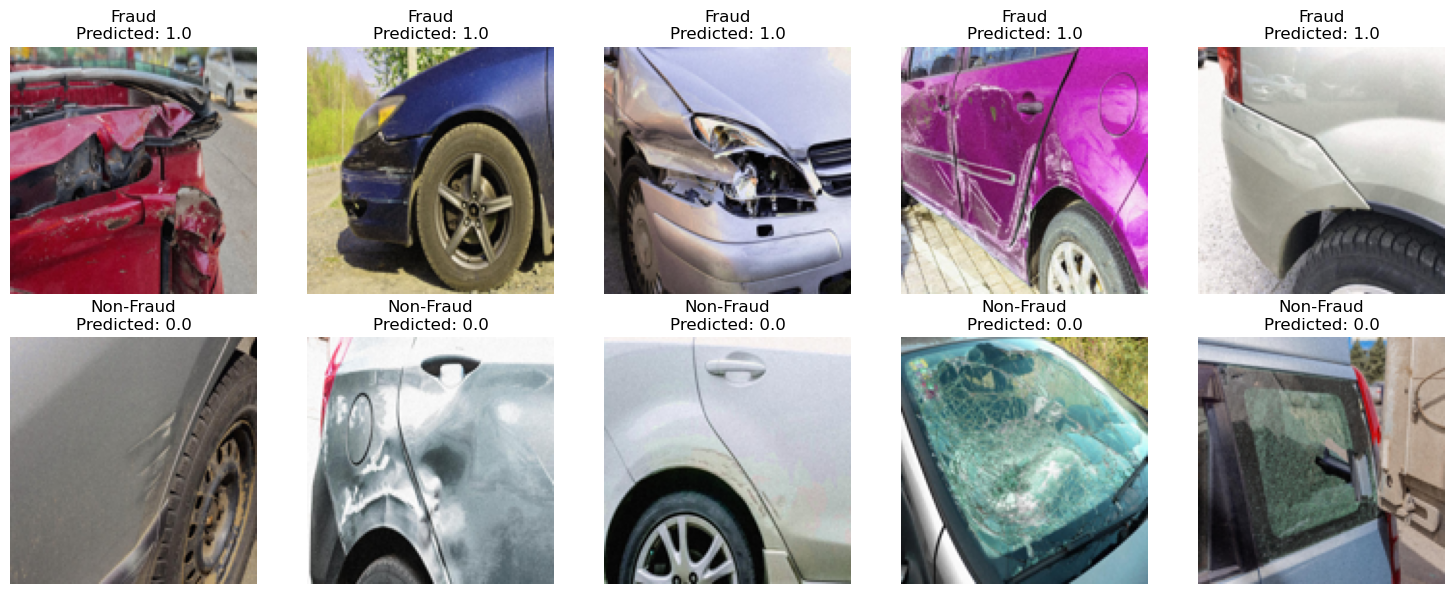

In [49]:
# function to plot fraud and non-fraud images along with their predicted labels
def plot_images(val_predictions_smote_rf, n=5):
    # filter fraud and non-fraud images
    fraud_images = val_predictions_smote_rf[val_predictions_smote_rf['predicted_label'] == 1]
    non_fraud_images = val_predictions_smote_rf[val_predictions_smote_rf['predicted_label'] == 0]
    
    # sample images safely
    num_fraud_samples = min(len(fraud_images), n)
    num_non_fraud_samples = min(len(non_fraud_images), n)

    # randomly sample images
    fraud_sample = fraud_images.sample(num_fraud_samples) if num_fraud_samples > 0 else pd.DataFrame(columns=val_predictions_smote_rf.columns)
    non_fraud_sample = non_fraud_images.sample(num_non_fraud_samples) if num_non_fraud_samples > 0 else pd.DataFrame(columns=val_predictions_smote_rf.columns)

    # create subplots
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    # plot fraud images
    for i, (index, row) in enumerate(fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        if img is not None and img.size > 0:  # Check if the image is valid and not empty
            axes[0, i].imshow(img)
            axes[0, i].set_title(f"Fraud\nPredicted: {row['predicted_label']}")
            axes[0, i].axis('off')
    
    # plot non-fraud images
    for i, (index, row) in enumerate(non_fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        if img is not None and img.size > 0:  # Check if the image is valid and not empty
            axes[1, i].imshow(img)
            axes[1, i].set_title(f"Non-Fraud\nPredicted: {row['predicted_label']}")
            axes[1, i].axis('off')

    # adjust layout and display
    plt.tight_layout()
    plt.show()

# display a few fraud and non-fraud images
plot_images(val_predictions_smote_rf, n=5)